In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import norm

import tensorflow.keras as keras
from keras import backend as k
k.clear_session()

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #resolving issue with keras killing kernel

# Autoencoder
neural network with unsupervised machine-learning algorithm apply back-prop to set target value to the input
auto-encoder prefers over PCA because it can learn non-linear transformations with non-linear activation functions. more efficient to learn several layer with auto-encoder then one huge transformation with PCA.

Autoencoder Applications
Image coloring (Black-white images -> colored)
Feature variation (Extract required feature)
Dimensionality Reduction
Denosing image (Remove Noise)
Remove watermark

Autoencoder Architecture
Encoder : part of NN compress the input into latent space representation
code : part of NN represents compressed input
Decoder : Decode the encoded data to original dimension

Properties of Autoencoder
Data-specific: Autoencoders are only able to meaningfully compress data similar to what they have been trained on.
Lossy: de-compressed output will be degrad compared to the original input
Unsupervised: Autoencoders are considered an unsupervised learning technique since they don’t need explicit labels to train on. But to be more precise they are self-supervised because they generate their own labels from the training data.

Types of Autoencoder
Denoising autoencoder.
Sparse Autoencoder.
Deep Autoencoder.
Contractive Autoencoder.
Undercomplete Autoencoder.
Convolutional Autoencoder.
Variational Autoencoder.

### Variational Autoencoder (convolutional)


In [2]:
# set parameter
image_shape = (28,28,1)
batch_size = 64
latent_dim = 10
epoch = 30

In [3]:
# Import the mnist dataset
from tensorflow.keras.datasets import mnist



# import minist dataset
(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()

In [4]:
# change datatype and reshape data
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + image_shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + image_shape)

In [5]:
# function to fatch 10 images of labeld 0 to 9
def get_images_1_to_10(x_train,y_train):
    selected_x,selected_y = [],[]
    for i in range(10):
        number_index = np.where(y_train == i)[0]
        random_index = np.random.choice(len(number_index),1,replace=False)
        select_index = number_index[random_index]
        selected_x.append(x_train[select_index[0]])
        selected_y.append(y_train[select_index][0])
    return np.array(selected_x,dtype="float32").reshape((len(selected_x),)+image_shape),np.array(selected_y,dtype="float32")
# select random 10 image of labeled 0 to 9
selected_x,selected_y =  get_images_1_to_10(x_train,y_train)

In [6]:
# function for plot images
def plot_image(selected_x,selected_y,title=None,save=None):
    ncols = selected_x.shape[0]
    fig,ax  = plt.subplots(nrows=1, ncols=ncols,figsize=(20,3))
    for x,y,ax_i in zip(selected_x,selected_y,ax):
        ax_i.imshow(x.reshape((28,28)))
        ax_i.axis("off")
        ax_i.set_title(int(y))
    if title:
        fig.suptitle(title)
    if save:
        fig.savefig(str(save)+".png")
    plt.show()

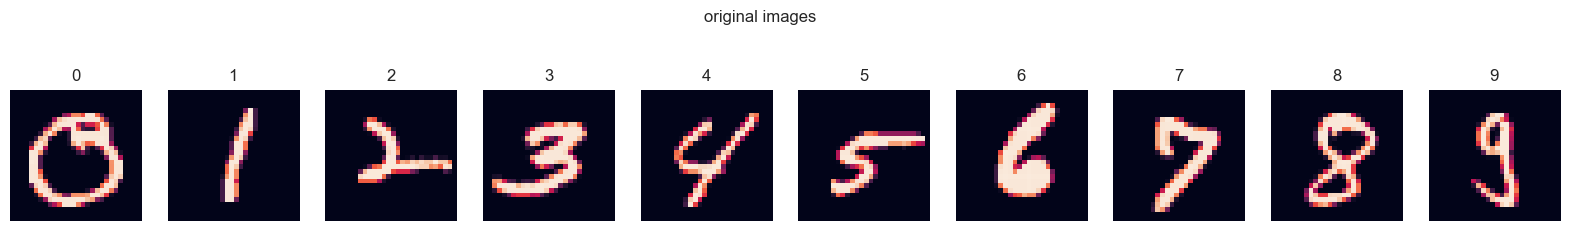

In [7]:
# plot selected images
plot_image(selected_x,selected_y,title="original images",save="original_images")

### Encoder implementation

In [8]:
# Input layer
# input shape = (None,28,28,1)
encoder_input = keras.Input(shape=image_shape)

# convolutional layer 1
# input shape = (None,28,28,1)
# output shape = (None,28,28,32)
conv_1 = keras.layers.Conv2D(filters=32,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                             )(encoder_input)

# convolutional layer 2
# input shape = (None,28,28,32)
# output shape = (None,28,28,64)
conv_2 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                             )(conv_1)

# convolutional layer 3
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_3 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                             )(conv_2)

# Flatten layer
# input shape = (None,28,28,64)
# output shape = (None,50176)
flatten = keras.layers.Flatten()(conv_3)

# Dense layer 1
# input shape = (None,50176)
# output shape = (None,128)
encoder_output = keras.layers.Dense(128,activation="relu")(flatten)

Latent space implementation


In [9]:
# latent mean and (log)variance

# Dense layer 2
# input shape = (None,128)
# output shape = (None,latent_dim)
z_mu = keras.layers.Dense(latent_dim)(encoder_output)

# Dense layer 3
# input shape = (None,128)
# output shape = (None,latent_dim)
z_log_sigma = keras.layers.Dense(latent_dim)(encoder_output)

In [10]:
# sampling function for latent layer
def sampling(args):
    z_mu, z_log_sigma = args

    # epsilon is simple normal distribution
    epsilon = k.random_normal(shape=(k.shape(z_mu)[0], latent_dim),mean=0., stddev=1.)
    return z_mu + k.exp(z_log_sigma) * epsilon

z = keras.layers.Lambda(sampling,output_shape=(latent_dim,))([z_mu, z_log_sigma])

Decoder implementation


In [11]:
# Dense layer 4
# input shape = (None,latent_dim)
# output shape = (None,128)
dense_2 = keras.layers.Dense(128,activation="relu")

# Dense layer 4
# input shape = (None,128)
# output shape = (None,50176)
dense_3 = keras.layers.Dense(np.prod(k.int_shape(conv_3)[1:]),
                             activation="relu"
                             )

# Reshape layer 
# input shape = (None,128)
# output shape = (None,28,28,64)
reshape = keras.layers.Reshape(k.int_shape(conv_3)[1:])

# Deconvolutional layer 1
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_4 = keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                      )
# Deconvolutional layer 2
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_5 = keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                      )

# Deconvolutional layer 3
# input shape = (None,28,28,64)
# output shape = (None,28,28,32)
conv_6 = keras.layers.Conv2DTranspose(filters=32,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                      )

# convolutional layer 4
# input shape = (None,28,28,32)
# output shape = (None,28,28,1)
decoder_output = keras.layers.Conv2D(filters=1,
                                     kernel_size=3,
                                     padding="same",
                                     activation="sigmoid"
                                     )

_dense_2 = dense_2(z)
_dense_3 = dense_3(_dense_2)
_reshape = reshape(_dense_3)
_conv_4 = conv_4(_reshape)
_conv_5 = conv_5(_conv_4)
_conv_6 = conv_6(_conv_5)
_decoder_output = decoder_output(_conv_6)

Loss Function

In [12]:
def vae_loss(x, z_decoded):
    x = k.flatten(x)
    z_decoded = k.flatten(z_decoded)
    # Reconstruction loss
    Reconstruction_loss = 786*keras.metrics.binary_crossentropy(x, z_decoded)
    # KL divergence
    kl_loss = -0.5 * k.mean(1 + z_log_sigma - k.square(z_mu) - k.exp(z_log_sigma), axis=-1)
    return Reconstruction_loss + kl_loss

Model compile and summary


In [13]:
variational_encoder = keras.Model(encoder_input,_decoder_output)
variational_encoder.compile(optimizer='rmsprop',loss=vae_loss)
variational_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 64)   36928       ['conv2d_1[0][0]']               
                                                                                              

Model plot


In [16]:
keras.utils.plot_model(variational_encoder,to_file="variational_encoder_L{}_E_{}.png".format(latent_dim,epoch),show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
conda install graphviz